# 目標
- 離散システムにおける、二次変分によるパラメータと状態変数の信頼区間推定 ← 途中
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装

## 離散システムにおける2nd order adjoint法の双子実験

T 5.0
day 25.0


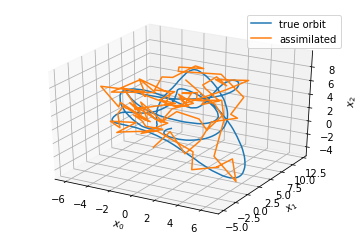

Before assimilation
cost 6709.43040628


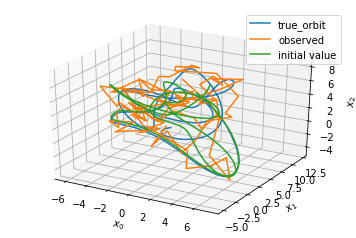

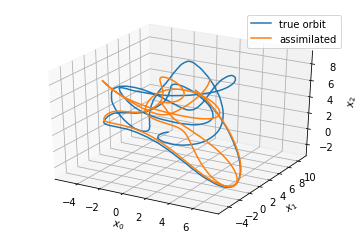

Analytical and numerical gradient comparison
gr_anal [ 29289.15369923  53603.67504749  69264.1037124  -34017.65265344
  17071.60828403  80070.40249618  -6863.14020743]
gr_num [ 29372.50194395  53839.27391368  69700.22735491 -33952.89361722
  17244.16995584  80316.12875476  -6849.49764659]
relative error [-0.00283763 -0.00437597 -0.00625713  0.00190732 -0.01000696 -0.00305949
  0.00199176]


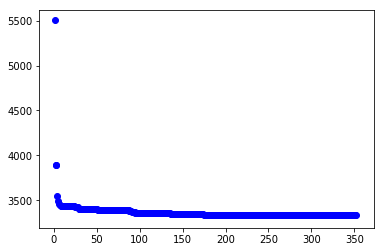

      fun: 3336.3852772258501
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.24117249, -2.1728054 ,  1.91135441, -0.32043992,  2.48356623,
        0.08865183, -0.21193473])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 490
      nit: 352
   status: 0
  success: True
        x: array([ 0.38692865,  5.32349504,  6.19240106, -0.57015352, -5.07060696,
        1.17313342,  2.05596553])
true x0 [ 1.699446  3.900173  5.906913 -3.182512 -5.098747  1.66392   2.095208]


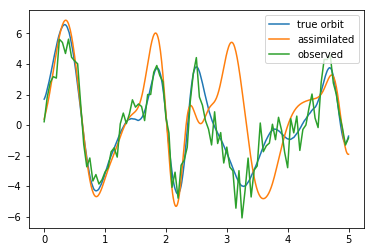

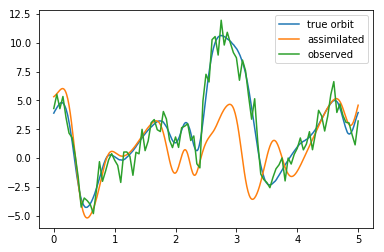

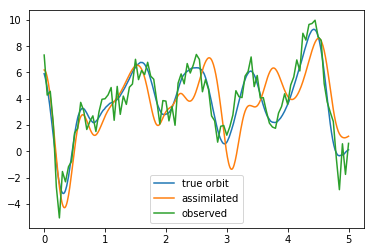

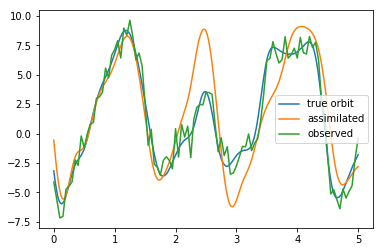

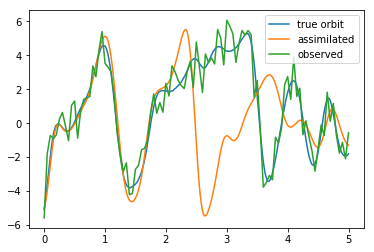

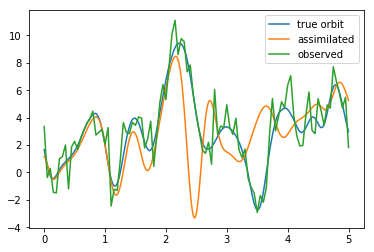

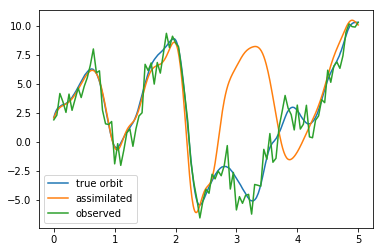

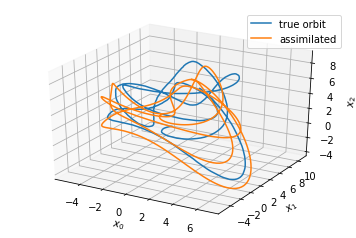

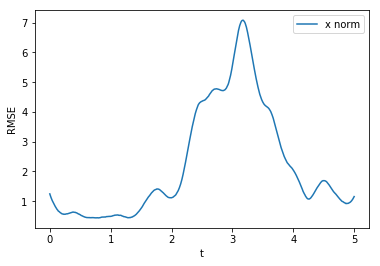

RMSE:  3.66167944209
hessian [[  3833452.07582981   2809800.65800692  -6661050.99736602
     650008.77188007  -4125118.84970358  -4285865.75808566
    -408240.25199496]
 [  2809800.65800692   2068214.72746937  -4846090.05878899
     474570.87775364  -3022454.63764425  -3096388.75380022
    -289757.17050152]
 [ -6661050.99736599  -4846090.05878898  11726827.26178486
   -1137300.40273147   7172979.16290418   7636655.37314793
     749742.74812655]
 [   650008.77188006    474570.87775364  -1137300.40273147
     110626.76237312   -699732.11127706   -736453.73181363
     -71293.39846662]
 [ -4125118.84970356  -3022454.63764424   7172979.16290418
    -699732.11127706   4439304.00869946   4618330.2010102
     440777.49090297]
 [ -4285865.75808566  -3096388.75380023   7636655.37314795
    -736453.73181363   4618330.20101022   5027130.45463319
     506619.23204537]
 [  -408240.25199495   -289757.17050152    749742.74812655
     -71293.39846662    440777.49090297    506619.23204537
      54341.31

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F, dt):
        self.N = N
        self.F = F
        self.dt = dt
        self.m = np.zeros((self.N, self.N))
        self.mm = np.zeros((self.N, self.N, self.N))
            
    def gradient(self, x, x_next):
        x_next[0] =        ((x[1]   - x[self.N-2]) * x[self.N-1] + self.F) * self.dt + x[0]        * (1. - self.dt)
        x_next[1] =        ((x[2]   - x[self.N-1]) * x[0]        + self.F) * self.dt + x[1]        * (1. - self.dt)
        for i in range(2, self.N-1):
            x_next[i] =    ((x[i+1] - x[i-2])      * x[i-1]      + self.F) * self.dt + x[i]        * (1. - self.dt)
        x_next[self.N-1] = ((x[0]   - x[self.N-3]) * x[self.N-2] + self.F) * self.dt + x[self.N-1] * (1. - self.dt)
        return x_next

    def tl(self, x):
        for i in range(self.N):
            for j in range(self.N):
                self.m[i,j] = self.dt * (((((i+1) % self.N) == j) - (((i-2) % self.N) == j)) * x[(i-1) % self.N] + (x[(i+1) % self.N] - x[(i-2) % self.N]) * (((i-1) % self.N) == j))\
                       + (1. - self.dt) * (i == j)
        return self.m
            
#    def gradient_adjoint(self, la, x):
#        return self.tl(x).transpose() @ la
    
    def gradient_adjoint(self, la, x):
        # fastest code
#        d = np.zeros(self.N)
#        for j in range(self.N):
#            d[j] = self.dt * (x[(j-2) % self.N] * la[(j-1) % self.N] - x[(j+1) % self.N] * la[(j+2) % self.N] + (x[(j+2) % self.N] - x[(j-1) % self.N]) * la[(j+1) % self.N])\
#                 + (1. - self.dt) * la[j]
#        return d
        return np.array([self.dt * (x[(j-2) % self.N] * la[(j-1) % self.N] - x[(j+1) % self.N] * la[(j+2) % self.N] + (x[(j+2) % self.N] - x[(j-1) % self.N]) * la[(j+1) % self.N])\
                 + (1. - self.dt) * la[j] for j in range(self.N)])

#    def gradient_adjoint(self, la, x):
#        d = np.zeros(self.N)
#        d[0]        = self.dt * (x[self.N-2] * la[self.N-1] - x[1]        * la[2]   + (x[2]   - x[self.N-1]) * la[1]       ) + (1. - self.dt) * la[0]
#        d[1]        = self.dt * (x[self.N-1] * la[0]        - x[2]        * la[3]   + (x[3]   - x[0]       ) * la[2]       ) + (1. - self.dt) * la[1]
#        for j in range(2, self.N-2):
#            d[j]    = self.dt * (x[j-2]      * la[j-1]      - x[j+1]      * la[j+2] + (x[j+2] - x[j-1]     ) * la[j+1]     ) + (1. - self.dt) * la[j]
#        d[self.N-2] = self.dt * (x[self.N-4] * la[self.N-3] - x[self.N-1] * la[0]   + (x[0]   - x[self.N-3]) * la[self.N-1]) + (1. - self.dt) * la[self.N-2]
#        d[self.N-1] = self.dt * (x[self.N-3] * la[self.N-2] - x[0]        * la[1]   + (x[1]   - x[self.N-2]) * la[0]       ) + (1. - self.dt) * la[self.N-1]
#        return d
        
#    def gradient_adjoint(self, la, x):
#        mt = np.zeros((self.N,self.N))
#        for i in range(self.N):
#            for j in range(self.N):
#                if (((i-1) % self.N) == (j % self.N)):
#                    mt[j][i] += self.dt * (x[(i+1) % self.N] - x[(i-2) % self.N])
#                if (((i+1) % self.N) == (j % self.N)):
#                    mt[j][i] += self.dt * x[(i-1) % self.N]
#                if (((i-2) % self.N) == (j % self.N)):
#                    mt[j][i] -= self.dt * x[(i-1) % self.N]
#                if ((i     % self.N) == (j % self.N)):
#                    mt[j][i] += 1. - self.dt
#        gr = mt @ la
#        return gr
    
    def gradient_neighboring(self, xi, x):
        return np.array([self.dt * (x[(i-1) % self.N] * (xi[(i+1) % self.N] - xi[(i-2) % self.N]) + (x[(i+1) % self.N] - x[(i-2) % self.N]) * xi[(i-1) % self.N]) + (1. - self.dt) * xi[i] for i in range(self.N)])
    
    def gradient_secondadj(self, nu, x, la, xi):
        # fastest code
#        d = np.zeros(self.N)
#        for i in range(N):
#            d[i] = self.dt * (x[(i-2) % self.N] * nu[(i-1) % self.N] - x[(i+1) % self.N] * nu[(i+2) % self.N] + (x[(i+2) % self.N] - x[(i-1) % self.N]) * nu[(i+1) % self.N]) + (1. - self.dt) * nu[i]\
#                 + self.dt * (xi[(i-2) % self.N] * la[(i-1) % self.N] - xi[(i+1) % self.N] * la[(i+2) % self.N] + (xi[(i+2) % self.N] - xi[(i-1) % self.N]) * la[(i+1) % self.N])\
#                 + xi[i]
#        return d
        return np.array([self.dt * (x[(i-2) % self.N] * nu[(i-1) % self.N] - x[(i+1) % self.N] * nu[(i+2) % self.N] + (x[(i+2) % self.N] - x[(i-1) % self.N]) * nu[(i+1) % self.N]) + (1. - self.dt) * nu[i]  + self.dt * (xi[(i-2) % self.N] * la[(i-1) % self.N] - xi[(i+1) % self.N] * la[(i+2) % self.N] + (xi[(i+2) % self.N] - xi[(i-1) % self.N]) * la[(i+1) % self.N])  for i in range(self.N)])

#    def tl_hessian(self, x):
#        for i in range(self.N):
#            for j in range(self.N):
#                for k in range(self.N):
#                    self.mm[i,j,k] = ( (((i+1) % self.N) == j) - (((i-2) % self.N) == j) ) * (((i-1) % self.N) == k)\
#                                   + ( (((i+1) % self.N) == k) - (((i-2) % self.N) == k) ) * (((i-1) % self.N) == j)
#        self.mm *= self.dt
#        return self.mm
#    
#    def gradient_secondadj(self, nu, x, la, xi):
#        return self.gradient_adjoint(nu, x) + (self.tl_hessian(x) @ xi).transpose() @ la
        
        
class Adjoint:
    def __init__(self, dx, dla, dxi, dnu, N, T, dt, it, obs_variance, x, y, la, xi, nu):
        self.dx = dx
        self.dla = dla
        self.dxi = dxi
        self.dnu = dnu
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.la = la
        self.xi = xi
        self.nu = nu
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.obs_variance = obs_variance
        
    def orbit(self):
        for i in range(self.minute_steps):
            handler(self.dx, self.x[i], self.x[i+1])
        return self.x
    
    def neighboring(self):
        for i in range(self.minute_steps):
            self.xi[i+1] = handler(self.dxi, self.xi[i], self.x[i])
        return self.xi
    
    def observed(self, stddev):
        self.orbit()
        self.x += stddev * np.random.randn(self.steps, self.N)
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        self.x += stddev * np.random.randn(self.steps, self.N)
        return tob, self.x
    
    def gradient(self):
        self.la[self.minute_steps] = (self.x[self.minute_steps] - self.y[self.steps])/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                self.la[n] = handler(self.dla, self.la[n+1], self.x[n]) # x should be current one.
            for j in range(self.N):
                self.la[self.it*i, j] += (self.x[self.it*i, j] - self.y[i, j])/self.obs_variance
        return self.la[0]

    def gradient_from_x0(self, x0):
        self.x[0] = x0
        self.orbit()
        self.la.fill(0.)
        return self.gradient()

    def hessian_vector_product(self, xi0):
        self.xi[0] = np.copy(xi0)
        self.neighboring()
        self.nu.fill(0.)
        self.nu[self.minute_steps] = self.xi[self.minute_steps]/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                self.nu[n] = handler(self.dnu, self.nu[n+1], self.x[n], self.la[n+1], self.xi[n]) # x and xi should be current one.
            for j in range(self.N):
                self.nu[self.it*i, j] += self.xi[self.it*i, j]/self.obs_variance
        return self.nu[0]
    
    def cost(self, x0):
        self.x[0] = x0
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i])
        return cost/self.obs_variance/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/self.obs_variance/2.0 # fixed
    
    def numerical_gradient_from_x0(self,x0,h):
        gr = np.zeros(N)
        c1 = self.cost(x0)
        for j in range(N):
            xx = np.copy(x0)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h
        return gr

    def numerical_hessian_from_x0(self, x0, h):
        hess = np.zeros((self.N, self.N))
        gr1 = np.copy(self.gradient_from_x0(x0))
#        print("gr1", gr1)
        for i in range(self.N):
            for j in range(self.N):
                xx = np.copy(x0)
                xx[j] += h
                gr2 = np.copy(self.gradient_from_x0(xx))
#                print("gr2", gr2)
#                print("(gr2 - gr1)", (gr2 - gr1))
                hess[j,i] = (gr2[i] - gr1[i])/h
#                print("")
#            print("")
        return hess
    
    def numerical_hessian_from_x0_2(self, x0, h):
        hess = np.zeros((self.N, self.N))
        gr1 = np.copy(self.numerical_gradient_from_x0(x0, h))
        for i in range(self.N):
            for j in range(self.N):
                xx = np.copy(x0)
                xx[j] += h
                gr2 = np.copy(self.numerical_gradient_from_x0(xx, h))
                hess[j,i] = (gr2[i] - gr1[i])/h
        return hess

    def cbf(self, x0):
        global count
        count += 1
        plt.scatter(count, self.cost(x0), c='b')
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
#pref = "data/" + str(N) + "/"
#pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_sysnoise_data/" + str(N) + "/"
#pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_discrete_data/" + str(N) + "/"
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_discrete_sysnoise_data/" + str(N) + "/"

F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 5.
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1.

lorenz = Lorenz96(N, F, dt)

tob = np.loadtxt(pref + "year.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_plus_1 = np.arange(0., T+dt, dt)
t_it = np.arange(0., T, dt*it)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

#x_opt = np.loadtxt(pref + "assimilation_xzero.2.dat")
x_opt = np.copy(tob[0]) + 0.001 * np.random.randn(N)

x  = np.zeros((minute_steps+1, N))
la = np.zeros((minute_steps+1, N))
xi = np.zeros((minute_steps+1, N))
nu = np.zeros((minute_steps+1, N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_neighboring, lorenz.gradient_secondadj, N, T, dt, it, stddev, x, obs, la, xi, nu)


print("Before assimilation")
print("cost", scheme.cost(x_opt))
compare_orbit3(tob[0:minute_steps+1], obs[0:steps+1], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps+1], scheme.x)

print("Analytical and numerical gradient comparison")
gr_anal = scheme.gradient_from_x0(x_opt)
print ("gr_anal", gr_anal)
gr_num = scheme.numerical_gradient_from_x0(x_opt, 0.0001)
print ("gr_num", gr_num)
print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
fig = plt.figure()
count = 0
#bnds = tuple([(-8., 24.) for i in range(N)])
res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
#res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
plt.show()
print (res)
print ("true x0", tob[0])
estimated_x0 = np.copy(res.x)

for j in range(N):
    fig = plt.figure()
    plt.plot(t_plus_1, tob[0:minute_steps+1,j], label='true orbit')
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.plot(t_it_plus_1, obs[0:steps+1,j], label='observed')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps+1], scheme.x)

#%%
fig = plt.figure()
plt.plot(t_plus_1, [np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(len(t_plus_1))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i] - tob[i])/math.sqrt(N) for i in range(int(len(t_plus_1)*0.4),int(len(t_plus_1)*0.6))]))


#%%
hessian_T = np.zeros((N, N))
xi0 = np.zeros(N)
for i in range(N):
    xi0.fill(0.)
    xi0[i] = 1.
    hessian_T[i] = np.copy(scheme.hessian_vector_product(xi0))

hessian = hessian_T.transpose()
hessian_inv = np.linalg.inv(hessian)
print("hessian", hessian)
#print("hessian_inverse", hessian_inv)
variance = np.diag(hessian_inv)
#print("variance", variance)

hess_num = scheme.numerical_hessian_from_x0(estimated_x0, 0.001)
print ("hessian_num", hess_num)

hess_num2 = scheme.numerical_hessian_from_x0_2(estimated_x0, 0.001)
print ("hessian_num2", hess_num2)


rel_error = (hessian - hess_num)/ hessian
print ("relative error", rel_error)

rel_error_2 = (hessian - hess_num2)/ hessian
print ("relative error2", rel_error_2)

abs_error = (hessian - hess_num)
print ("absolute error", abs_error)

abs_error_2 = (hessian - hess_num2)
print ("absolute error2", abs_error_2)

hess_num2_inv = np.linalg.inv(hess_num2)

#%%
print('4DVar optimal cost: ', res.fun)
scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_neighboring, lorenz.gradient_secondadj, N, T, dt, it, stddev, tob, obs, la, xi, nu)
print('true cost: ', scheme_true.true_cost())


## 離散システムにおけるシステムノイズありの2nd order adjoint法の双子実験

T 5.0
day 25.0


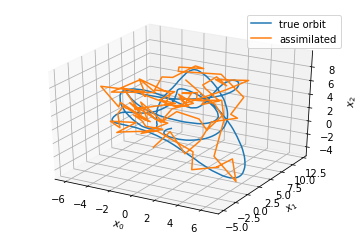

Before assimilation
cost 6857.47134875


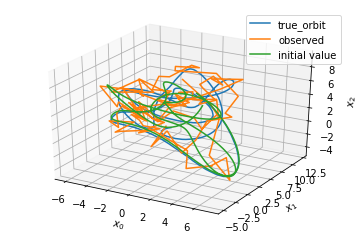

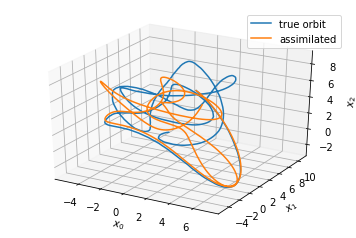

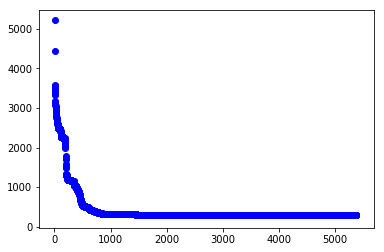

true x0 [ 1.699446  3.900173  5.906913 -3.182512 -5.098747  1.66392   2.095208]


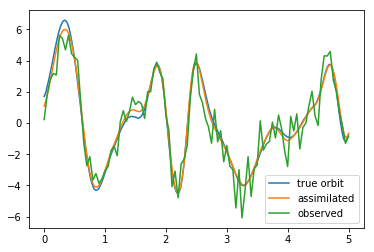

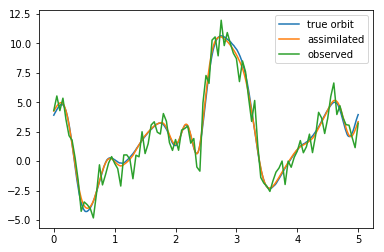

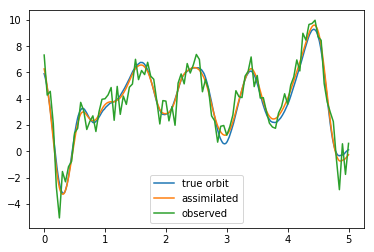

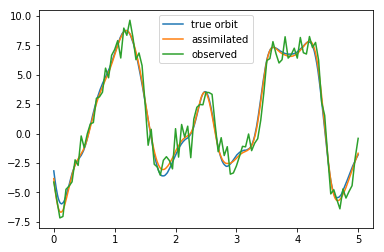

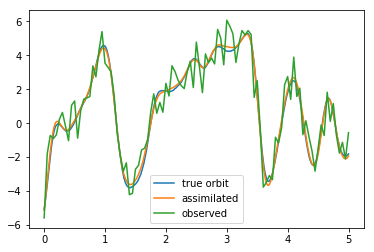

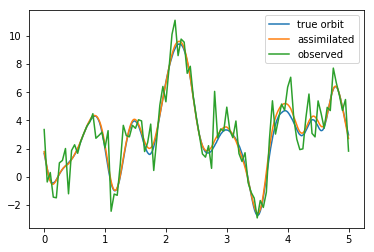

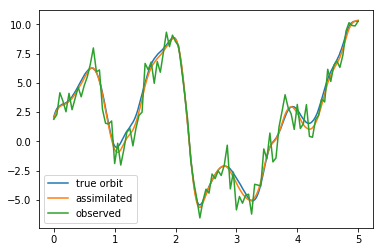

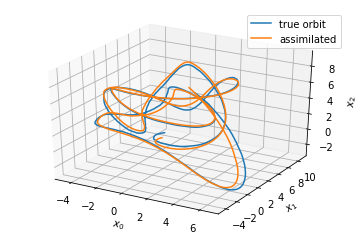

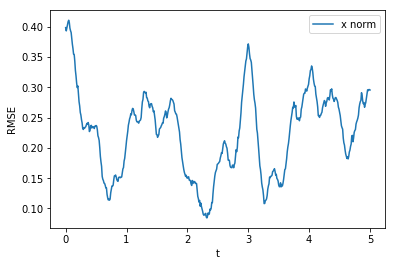

RMSE:  0.172163643564
hessian [[  4718677.35664439   8516617.97786    -10521772.91969221
    2163679.2543184   -6678711.68258665  -1966263.22581051
   -4047815.60379179]
 [  8516617.97786002  15373957.26937572 -18999139.18599994
    3907975.64396492 -12059580.12423749  -3554046.0913041
   -7310644.30308749]
 [-10521772.9196923  -18999139.1860001   23494483.50548005
   -4835532.53576574  14912219.05742808   4404129.22754939
    9043284.87071877]
 [  2163679.2543184    3907975.64396493  -4835532.5357657
     995798.23229235  -3069018.06879338   -908170.85557596
   -1861769.50652783]
 [ -6678711.68258668 -12059580.12423752  14912219.05742798
   -3069018.06879338   9465070.78393887   2794963.89225253
    5739844.32790063]
 [ -1966263.22581051  -3554046.09130413   4404129.22754936
    -908170.85557596   2794963.89225254    831196.70786868
    1697148.8491988 ]
 [ -4047815.60379183  -7310644.30308754   9043284.87071874
   -1861769.50652784   5739844.32790066   1697148.8491988
    3481831.825

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F, dt):
        self.N = N
        self.F = F
        self.dt = dt
        self.m = np.zeros((self.N, self.N))
        self.mm = np.zeros((self.N, self.N, self.N))
            
    def gradient(self, x, x_next):
        x_next[0] =        ((x[1]   - x[self.N-2]) * x[self.N-1] + self.F) * self.dt + x[0]        * (1. - self.dt)
        x_next[1] =        ((x[2]   - x[self.N-1]) * x[0]        + self.F) * self.dt + x[1]        * (1. - self.dt)
        for i in range(2, self.N-1):
            x_next[i] =    ((x[i+1] - x[i-2])      * x[i-1]      + self.F) * self.dt + x[i]        * (1. - self.dt)
        x_next[self.N-1] = ((x[0]   - x[self.N-3]) * x[self.N-2] + self.F) * self.dt + x[self.N-1] * (1. - self.dt)
        return x_next

    def tl(self, x):
        for i in range(self.N):
            for j in range(self.N):
                self.m[i,j] = self.dt * (((((i+1) % self.N) == j) - (((i-2) % self.N) == j)) * x[(i-1) % self.N] + (x[(i+1) % self.N] - x[(i-2) % self.N]) * (((i-1) % self.N) == j))\
                       + (1. - self.dt) * (i == j)
        return self.m
            
#    def gradient_adjoint(self, la, x):
#        return self.tl(x).transpose() @ la
    
    def gradient_adjoint(self, la, x):
        # fastest code
#        d = np.zeros(self.N)
#        for j in range(self.N):
#            d[j] = self.dt * (x[(j-2) % self.N] * la[(j-1) % self.N] - x[(j+1) % self.N] * la[(j+2) % self.N] + (x[(j+2) % self.N] - x[(j-1) % self.N]) * la[(j+1) % self.N])\
#                 + (1. - self.dt) * la[j]
#        return d
        return np.array([self.dt * (x[(j-2) % self.N] * la[(j-1) % self.N] - x[(j+1) % self.N] * la[(j+2) % self.N] + (x[(j+2) % self.N] - x[(j-1) % self.N]) * la[(j+1) % self.N])\
                 + (1. - self.dt) * la[j] for j in range(self.N)])

#    def gradient_adjoint(self, la, x):
#        d = np.zeros(self.N)
#        d[0]        = self.dt * (x[self.N-2] * la[self.N-1] - x[1]        * la[2]   + (x[2]   - x[self.N-1]) * la[1]       ) + (1. - self.dt) * la[0]
#        d[1]        = self.dt * (x[self.N-1] * la[0]        - x[2]        * la[3]   + (x[3]   - x[0]       ) * la[2]       ) + (1. - self.dt) * la[1]
#        for j in range(2, self.N-2):
#            d[j]    = self.dt * (x[j-2]      * la[j-1]      - x[j+1]      * la[j+2] + (x[j+2] - x[j-1]     ) * la[j+1]     ) + (1. - self.dt) * la[j]
#        d[self.N-2] = self.dt * (x[self.N-4] * la[self.N-3] - x[self.N-1] * la[0]   + (x[0]   - x[self.N-3]) * la[self.N-1]) + (1. - self.dt) * la[self.N-2]
#        d[self.N-1] = self.dt * (x[self.N-3] * la[self.N-2] - x[0]        * la[1]   + (x[1]   - x[self.N-2]) * la[0]       ) + (1. - self.dt) * la[self.N-1]
#        return d
        
#    def gradient_adjoint(self, la, x):
#        mt = np.zeros((self.N,self.N))
#        for i in range(self.N):
#            for j in range(self.N):
#                if (((i-1) % self.N) == (j % self.N)):
#                    mt[j][i] += self.dt * (x[(i+1) % self.N] - x[(i-2) % self.N])
#                if (((i+1) % self.N) == (j % self.N)):
#                    mt[j][i] += self.dt * x[(i-1) % self.N]
#                if (((i-2) % self.N) == (j % self.N)):
#                    mt[j][i] -= self.dt * x[(i-1) % self.N]
#                if ((i     % self.N) == (j % self.N)):
#                    mt[j][i] += 1. - self.dt
#        gr = mt @ la
#        return gr
    
    def gradient_neighboring(self, xi, x):
        return np.array([self.dt * (x[(i-1) % self.N] * (xi[(i+1) % self.N] - xi[(i-2) % self.N]) + (x[(i+1) % self.N] - x[(i-2) % self.N]) * xi[(i-1) % self.N]) + (1. - self.dt) * xi[i] for i in range(self.N)])
    
    def gradient_secondadj(self, nu, x, la, xi):
        # fastest code
#        d = np.zeros(self.N)
#        for i in range(N):
#            d[i] = self.dt * (x[(i-2) % self.N] * nu[(i-1) % self.N] - x[(i+1) % self.N] * nu[(i+2) % self.N] + (x[(i+2) % self.N] - x[(i-1) % self.N]) * nu[(i+1) % self.N]) + (1. - self.dt) * nu[i]\
#                 + self.dt * (xi[(i-2) % self.N] * la[(i-1) % self.N] - xi[(i+1) % self.N] * la[(i+2) % self.N] + (xi[(i+2) % self.N] - xi[(i-1) % self.N]) * la[(i+1) % self.N])\
#                 + xi[i]
#        return d
        return np.array([self.dt * (x[(i-2) % self.N] * nu[(i-1) % self.N] - x[(i+1) % self.N] * nu[(i+2) % self.N] + (x[(i+2) % self.N] - x[(i-1) % self.N]) * nu[(i+1) % self.N]) + (1. - self.dt) * nu[i]  + self.dt * (xi[(i-2) % self.N] * la[(i-1) % self.N] - xi[(i+1) % self.N] * la[(i+2) % self.N] + (xi[(i+2) % self.N] - xi[(i-1) % self.N]) * la[(i+1) % self.N])  for i in range(self.N)])

#    def tl_hessian(self, x):
#        for i in range(self.N):
#            for j in range(self.N):
#                for k in range(self.N):
#                    self.mm[i,j,k] = ( (((i+1) % self.N) == j) - (((i-2) % self.N) == j) ) * (((i-1) % self.N) == k)\
#                                   + ( (((i+1) % self.N) == k) - (((i-2) % self.N) == k) ) * (((i-1) % self.N) == j)
#        self.mm *= self.dt
#        return self.mm
#    
#    def gradient_secondadj(self, nu, x, la, xi):
#        return self.gradient_adjoint(nu, x) + (self.tl_hessian(x) @ xi).transpose() @ la
        
        
class Adjoint:
    def __init__(self, dx, dla, dxi, dnu, N, T, dt, it, obs_variance, sysnoise_variance, x, y, la, xi, nu, q, dq):
        self.dx = dx
        self.dla = dla
        self.dxi = dxi
        self.dnu = dnu
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.la = la
        self.xi = xi
        self.nu = nu
        self.q = q
        self.dq = dq
        self.it = it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.obs_variance = obs_variance
        self.sysnoise_variance = sysnoise_variance
        self.gr = np.zeros((self.minute_steps + 1) * self.N)
        
    def orbit(self):
        for i in range(self.minute_steps):
            handler(self.dx, self.x[i], self.x[i+1])
            self.x[i+1] += self.q[i]
        return self.x
    
    def neighboring(self):
        for i in range(self.minute_steps):
            self.xi[i+1] = handler(self.dxi, self.xi[i], self.x[i]) + self.dq[i]
        return self.xi
    
    def observed(self, stddev):
        self.orbit()
        self.x += stddev * np.random.randn(self.steps, self.N)
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        self.x += stddev * np.random.randn(self.steps, self.N)
        return tob, self.x
    
    def gradient(self):
        self.la[self.minute_steps] = (self.x[self.minute_steps] - self.y[self.steps])/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                self.la[n] = handler(self.dla, self.la[n+1], self.x[n]) # x should be current one.
            for j in range(self.N):
                self.la[self.it*i, j] += (self.x[self.it*i, j] - self.y[i, j])/self.obs_variance
        return self.la[0]

    def gradient_from_x0(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N])
        for i in range(self.minute_steps):
            self.q[i] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        self.la.fill(0.)
        self.gradient()
        self.gr[:self.N] = self.la[0]
        for n in range(self.minute_steps):
            self.gr[self.N*(n+1) : self.N*(n+2)] = la[n+1] + self.q[n]/self.sysnoise_variance
        return self.gr

    def hessian_vector_product(self, xi0):
        self.xi[0] = np.copy(xi0)
        self.neighboring()
        self.nu.fill(0.)
        self.nu[self.minute_steps] = self.xi[self.minute_steps]/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                self.nu[n] = handler(self.dnu, self.nu[n+1], self.x[n], self.la[n+1], self.xi[n]) # x and xi should be current one.
            for j in range(self.N):
                self.nu[self.it*i, j] += self.xi[self.it*i, j]/self.obs_variance
        return self.nu[0]
    
    def cost(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N])
        for i in range(self.minute_steps):
            self.q[i] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i])/self.obs_variance
        for i in range(self.minute_steps):
            cost += self.q[i] @ self.q[i] / self.sysnoise_variance
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/self.obs_variance/2.0 # fixed
    
    def numerical_gradient_from_x0(self, x0_q, h):
        gr = np.zeros(self.N * (self.minute_steps+1))
        c1 = self.cost(x0_q)
        for j in range(self.N * (self.minute_steps+1)):
            xx = np.copy(x0_q)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h        
        return gr
    
    def numerical_hessian_from_x0(self, x0, h):
        hess = np.zeros((self.N, self.N))
        gr1 = np.copy(self.gradient_from_x0(x0))
#        print("gr1", gr1)
        for i in range(self.N):
            for j in range(self.N):
                xx = np.copy(x0)
                xx[j] += h
                gr2 = np.copy(self.gradient_from_x0(xx))
#                print("gr2", gr2)
#                print("(gr2 - gr1)", (gr2 - gr1))
                hess[j,i] = (gr2[i] - gr1[i])/h
#                print("")
#            print("")
        return hess
    
    def numerical_hessian_from_x0_2(self, x0, h):
        hess = np.zeros((self.N, self.N))
        gr1 = np.copy(self.numerical_gradient_from_x0(x0, h))
        for i in range(self.N):
            for j in range(self.N):
                xx = np.copy(x0)
                xx[j] += h
                gr2 = np.copy(self.numerical_gradient_from_x0(xx, h))
                hess[j,i] = (gr2[i] - gr1[i])/h
        return hess

    def cbf(self, x0):
        global count
        count += 1
        plt.scatter(count, self.cost(x0), c='b')
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
#pref = "data/" + str(N) + "/"
#pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_sysnoise_data/" + str(N) + "/"
#pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_discrete_data/" + str(N) + "/"
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_discrete_sysnoise_data/" + str(N) + "/"

F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 5.
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1.
sysnoise_variance = 0.01

lorenz = Lorenz96(N, F, dt)

tob = np.loadtxt(pref + "year.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_plus_1 = np.arange(0., T+dt, dt)
t_it = np.arange(0., T, dt*it)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

x_opt_q = np.zeros((minute_steps + 1) * N)
x_opt_q[:N] = np.copy(tob[0]) + 0.001 * np.random.randn(N)
#x_opt_q[:N] = np.loadtxt(pref + "assimilation_xzero.2.dat")
#x_opt_q[:N] = np.copy(obs[0])

x  = np.zeros((minute_steps+1, N))
la = np.zeros((minute_steps+1, N))
xi = np.zeros((minute_steps+1, N))
nu = np.zeros((minute_steps+1, N))
q  = np.zeros((minute_steps ,N))
dq = np.zeros((minute_steps, N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_neighboring, lorenz.gradient_secondadj, N, T, dt, it, stddev, sysnoise_variance, x, obs, la, xi, nu, q, dq)

print("Before assimilation")
print("cost", scheme.cost(x_opt_q))
compare_orbit3(tob[0:minute_steps+1], obs[0:steps+1], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps+1], scheme.x)

#print("Analytical and numerical gradient comparison")
#gr_anal = scheme.gradient_from_x0(x_opt_q)
#print ("gr_anal", gr_anal)
#gr_num = scheme.numerical_gradient_from_x0(x_opt_q, 0.0001)
#print ("gr_num", gr_num)
#print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
fig = plt.figure()
count = 0
#bnds = tuple([(-8., 24.) for i in range(N)])
res = minimize(scheme.cost, x_opt_q, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
#res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
plt.show()
#print (res)
print ("true x0", tob[0])
estimated_x0 = np.copy(res.x)

for j in range(N):
    fig = plt.figure()
    plt.plot(t_plus_1, tob[0:minute_steps+1,j], label='true orbit')
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.plot(t_it_plus_1, obs[0:steps+1,j], label='observed')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps+1], scheme.x[:,0:N])

#%%
fig = plt.figure()
plt.plot(t_plus_1, [np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(len(t_plus_1))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(int(len(t_plus_1)*0.4),int(len(t_plus_1)*0.6))]))


#%%
hessian_T = np.zeros((N, N))
xi0 = np.zeros(N)
for i in range(N):
    xi0.fill(0.)
    xi0[i] = 1.
    hessian_T[i] = np.copy(scheme.hessian_vector_product(xi0))

hessian = hessian_T.transpose()
hessian_inv = np.linalg.inv(hessian)
print("hessian", hessian)
#print("hessian_inverse", hessian_inv)
variance = np.diag(hessian_inv)
#print("variance", variance)

hess_num = scheme.numerical_hessian_from_x0(estimated_x0, 0.001)
print ("hessian_num", hess_num)

#hess_num2 = scheme.numerical_hessian_from_x0_2(estimated_x0, 0.001)
#print ("hessian_num2", hess_num2)


rel_error = (hessian - hess_num)/ hessian
print ("relative error", rel_error)

#rel_error_2 = (hessian - hess_num2)/ hessian
#print ("relative error2", rel_error_2)

abs_error = (hessian - hess_num)
print ("absolute error", abs_error)

#abs_error_2 = (hessian - hess_num2)
#print ("absolute error2", abs_error_2)

hess_num_inv = np.linalg.inv(hess_num)

##%%
#print('4DVar optimal cost: ', res.fun)
#scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_neighboring, lorenz.gradient_secondadj, N, T, dt, it, stddev, tob, obs, la, xi, nu)
#print('true cost: ', scheme_true.true_cost())


## システムノイズを時間的にスパースに入れた場合

T 5.0
day 25.0


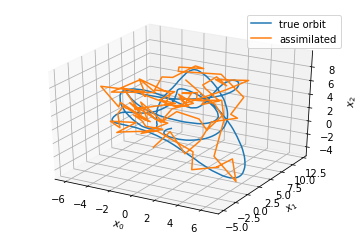

Before assimilation
cost 6917.41604374


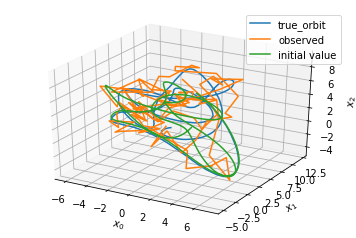

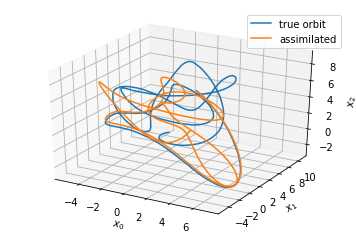

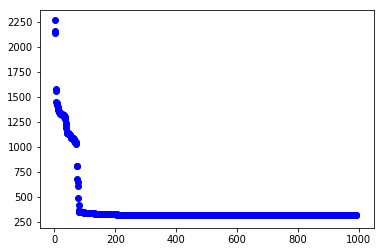

true x0 [ 1.699446  3.900173  5.906913 -3.182512 -5.098747  1.66392   2.095208]


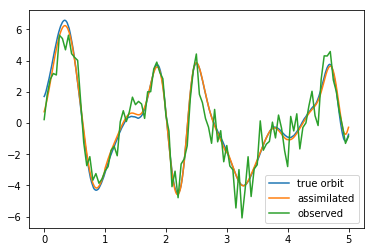

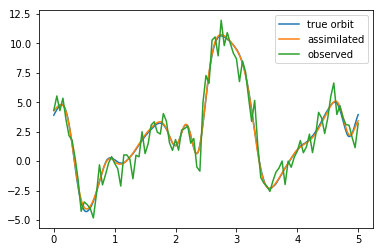

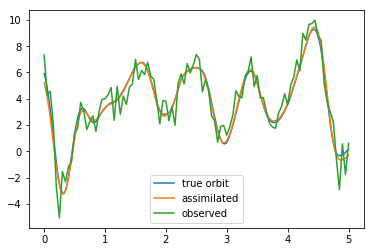

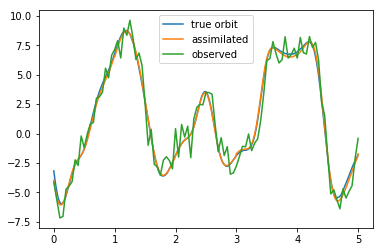

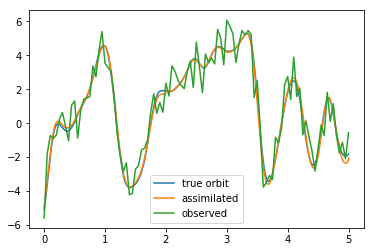

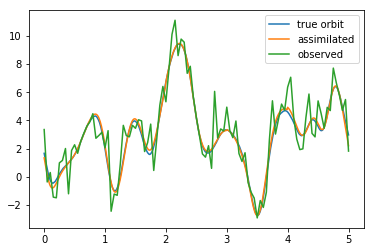

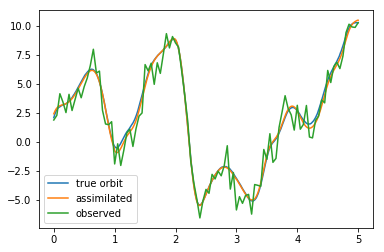

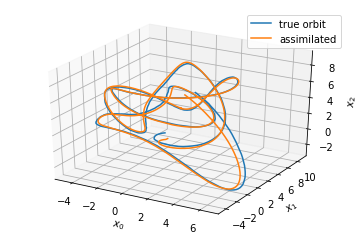

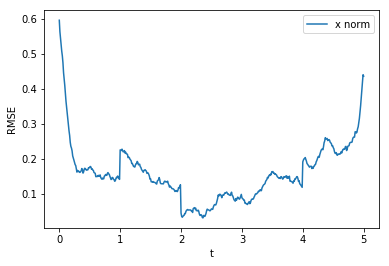

RMSE:  0.0676055883586
hessian [[  2041566.48512488   3418005.29801926  -4017615.90557538
    1319541.68083603  -2696948.70658223   -572927.5108606
    -763037.00835386]
 [  3659154.04732354   6126757.42918817  -7202019.8092495
    2365454.27139526  -4834605.08591079  -1027589.39777676
   -1368485.41135638]
 [ -5078380.59765458  -8503933.25063294  10004069.32091248
   -3285521.53788501   6715156.34451801   1431652.84651449
    1902354.55331922]
 [  1192905.86876855   1997669.7100235   -2351392.65787327
     772253.5397021   -1578268.10904686   -337235.73469464
    -447318.29923484]
 [ -3526625.80009783  -5905430.92873064   6946243.94308159
   -2281309.39049498   4662725.41663472    993585.69470392
    1320794.19817675]
 [ -1030517.71803173  -1726328.35425215   2034827.33142255
    -668190.1297983    1365672.58104839    293565.77240589
     387935.86535774]
 [ -1254193.4215908   -2100790.57389758   2471962.83216147
    -811838.90040431   1659314.87845541    354369.65929193
     470778.4

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F, dt):
        self.N = N
        self.F = F
        self.dt = dt
        self.m = np.zeros((self.N, self.N))
        self.mm = np.zeros((self.N, self.N, self.N))
            
    def gradient(self, x, x_next):
        x_next[0] =        ((x[1]   - x[self.N-2]) * x[self.N-1] + self.F) * self.dt + x[0]        * (1. - self.dt)
        x_next[1] =        ((x[2]   - x[self.N-1]) * x[0]        + self.F) * self.dt + x[1]        * (1. - self.dt)
        for i in range(2, self.N-1):
            x_next[i] =    ((x[i+1] - x[i-2])      * x[i-1]      + self.F) * self.dt + x[i]        * (1. - self.dt)
        x_next[self.N-1] = ((x[0]   - x[self.N-3]) * x[self.N-2] + self.F) * self.dt + x[self.N-1] * (1. - self.dt)
        return x_next

    def tl(self, x):
        for i in range(self.N):
            for j in range(self.N):
                self.m[i,j] = self.dt * (((((i+1) % self.N) == j) - (((i-2) % self.N) == j)) * x[(i-1) % self.N] + (x[(i+1) % self.N] - x[(i-2) % self.N]) * (((i-1) % self.N) == j))\
                       + (1. - self.dt) * (i == j)
        return self.m
            
#    def gradient_adjoint(self, la, x):
#        return self.tl(x).transpose() @ la
    
    def gradient_adjoint(self, la, x):
        # fastest code
#        d = np.zeros(self.N)
#        for j in range(self.N):
#            d[j] = self.dt * (x[(j-2) % self.N] * la[(j-1) % self.N] - x[(j+1) % self.N] * la[(j+2) % self.N] + (x[(j+2) % self.N] - x[(j-1) % self.N]) * la[(j+1) % self.N])\
#                 + (1. - self.dt) * la[j]
#        return d
        return np.array([self.dt * (x[(j-2) % self.N] * la[(j-1) % self.N] - x[(j+1) % self.N] * la[(j+2) % self.N] + (x[(j+2) % self.N] - x[(j-1) % self.N]) * la[(j+1) % self.N])\
                 + (1. - self.dt) * la[j] for j in range(self.N)])

#    def gradient_adjoint(self, la, x):
#        d = np.zeros(self.N)
#        d[0]        = self.dt * (x[self.N-2] * la[self.N-1] - x[1]        * la[2]   + (x[2]   - x[self.N-1]) * la[1]       ) + (1. - self.dt) * la[0]
#        d[1]        = self.dt * (x[self.N-1] * la[0]        - x[2]        * la[3]   + (x[3]   - x[0]       ) * la[2]       ) + (1. - self.dt) * la[1]
#        for j in range(2, self.N-2):
#            d[j]    = self.dt * (x[j-2]      * la[j-1]      - x[j+1]      * la[j+2] + (x[j+2] - x[j-1]     ) * la[j+1]     ) + (1. - self.dt) * la[j]
#        d[self.N-2] = self.dt * (x[self.N-4] * la[self.N-3] - x[self.N-1] * la[0]   + (x[0]   - x[self.N-3]) * la[self.N-1]) + (1. - self.dt) * la[self.N-2]
#        d[self.N-1] = self.dt * (x[self.N-3] * la[self.N-2] - x[0]        * la[1]   + (x[1]   - x[self.N-2]) * la[0]       ) + (1. - self.dt) * la[self.N-1]
#        return d
        
#    def gradient_adjoint(self, la, x):
#        mt = np.zeros((self.N,self.N))
#        for i in range(self.N):
#            for j in range(self.N):
#                if (((i-1) % self.N) == (j % self.N)):
#                    mt[j][i] += self.dt * (x[(i+1) % self.N] - x[(i-2) % self.N])
#                if (((i+1) % self.N) == (j % self.N)):
#                    mt[j][i] += self.dt * x[(i-1) % self.N]
#                if (((i-2) % self.N) == (j % self.N)):
#                    mt[j][i] -= self.dt * x[(i-1) % self.N]
#                if ((i     % self.N) == (j % self.N)):
#                    mt[j][i] += 1. - self.dt
#        gr = mt @ la
#        return gr
    
    def gradient_neighboring(self, xi, x):
        return np.array([self.dt * (x[(i-1) % self.N] * (xi[(i+1) % self.N] - xi[(i-2) % self.N]) + (x[(i+1) % self.N] - x[(i-2) % self.N]) * xi[(i-1) % self.N]) + (1. - self.dt) * xi[i] for i in range(self.N)])
    
    def gradient_secondadj(self, nu, x, la, xi):
        # fastest code
#        d = np.zeros(self.N)
#        for i in range(N):
#            d[i] = self.dt * (x[(i-2) % self.N] * nu[(i-1) % self.N] - x[(i+1) % self.N] * nu[(i+2) % self.N] + (x[(i+2) % self.N] - x[(i-1) % self.N]) * nu[(i+1) % self.N]) + (1. - self.dt) * nu[i]\
#                 + self.dt * (xi[(i-2) % self.N] * la[(i-1) % self.N] - xi[(i+1) % self.N] * la[(i+2) % self.N] + (xi[(i+2) % self.N] - xi[(i-1) % self.N]) * la[(i+1) % self.N])\
#                 + xi[i]
#        return d
        return np.array([self.dt * (x[(i-2) % self.N] * nu[(i-1) % self.N] - x[(i+1) % self.N] * nu[(i+2) % self.N] + (x[(i+2) % self.N] - x[(i-1) % self.N]) * nu[(i+1) % self.N]) + (1. - self.dt) * nu[i]  + self.dt * (xi[(i-2) % self.N] * la[(i-1) % self.N] - xi[(i+1) % self.N] * la[(i+2) % self.N] + (xi[(i+2) % self.N] - xi[(i-1) % self.N]) * la[(i+1) % self.N])  for i in range(self.N)])

#    def tl_hessian(self, x):
#        for i in range(self.N):
#            for j in range(self.N):
#                for k in range(self.N):
#                    self.mm[i,j,k] = ( (((i+1) % self.N) == j) - (((i-2) % self.N) == j) ) * (((i-1) % self.N) == k)\
#                                   + ( (((i+1) % self.N) == k) - (((i-2) % self.N) == k) ) * (((i-1) % self.N) == j)
#        self.mm *= self.dt
#        return self.mm
#    
#    def gradient_secondadj(self, nu, x, la, xi):
#        return self.gradient_adjoint(nu, x) + (self.tl_hessian(x) @ xi).transpose() @ la
        
        
class Adjoint:
    def __init__(self, dx, dla, dxi, dnu, N, T, dt, it, sysnoise_it, obs_variance, sysnoise_variance, x, y, la, xi, nu, q, dq):
        self.dx = dx
        self.dla = dla
        self.dxi = dxi
        self.dnu = dnu
        self.N = N
        self.T = T
        self.dt = dt
        self.x = x
        self.y = y
        self.la = la
        self.xi = xi
        self.nu = nu
        self.q = q
        self.dq = dq
        self.it = it
        self.sysnoise_it = sysnoise_it
        self.minute_steps = int(T/self.dt)
        self.steps = int(self.minute_steps/it)
        self.sysnoise_steps = int(self.minute_steps/sysnoise_it)
        self.obs_variance = obs_variance
        self.sysnoise_variance = sysnoise_variance
        self.gr = np.zeros((self.sysnoise_steps + 1) * self.N)
        
    def orbit(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                handler(self.dx, self.x[n], self.x[n+1])
            self.x[self.sysnoise_it*(i+1)] += self.q[i]
        return self.x
    
    def neighboring(self):
        for i in range(self.sysnoise_steps):
            for j in range(self.sysnoise_it):
                n = self.sysnoise_it*i + j
                self.xi[n+1] = handler(self.dxi, self.xi[n], self.x[n])
            self.xi[self.sysnoise_it*(i+1)] += self.q[i]
        return self.xi
    
    def observed(self, stddev):
        self.orbit()
        self.x += stddev * np.random.randn(self.steps, self.N)
        return self.x

    def true_observed(self, stddev):
        tob = np.copy(self.orbit())
        self.x += stddev * np.random.randn(self.steps, self.N)
        return tob, self.x
    
    def gradient(self):
        self.la[self.minute_steps] = (self.x[self.minute_steps] - self.y[self.steps])/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                self.la[n] = handler(self.dla, self.la[n+1], self.x[n]) # x should be current one.
            for j in range(self.N):
                self.la[self.it*i, j] += (self.x[self.it*i, j] - self.y[i, j])/self.obs_variance
        return self.la[0]

    def gradient_from_x0(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N])
        for i in range(self.sysnoise_steps):
            self.q[i] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        self.la.fill(0.)
        self.gr.fill(0.)
        self.gradient()
        self.gr[:self.N] = self.la[0]
        for i in range(self.sysnoise_steps):
            self.gr[self.N*(i+1) : self.N*(i+2)] = la[self.sysnoise_it*(i+1)] + self.q[i]/self.sysnoise_variance
        return self.gr

    def hessian_vector_product(self, xi0):
        self.xi[0] = np.copy(xi0)
        self.neighboring()
        self.nu.fill(0.)
        self.nu[self.minute_steps] = self.xi[self.minute_steps]/self.obs_variance
        for i in range(self.steps-1, -1, -1):
            for j in range(it-1, -1, -1):
                n = self.it*i + j
                self.nu[n] = handler(self.dnu, self.nu[n+1], self.x[n], self.la[n+1], self.xi[n]) # x and xi should be current one.
            for j in range(self.N):
                self.nu[self.it*i, j] += self.xi[self.it*i, j]/self.obs_variance
        return self.nu[0]
    
    def cost(self, x0_q):
        self.x[0] = np.copy(x0_q[:self.N])
        for i in range(self.sysnoise_steps):
            self.q[i] = x0_q[self.N*(i+1) : self.N*(i+2)]
        self.orbit()
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
#            print ((self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i]))
            cost += (self.x[self.it*i] - self.y[i]) @ (self.x[self.it*i] - self.y[i])/self.obs_variance
        for i in range(self.sysnoise_steps):
            cost += self.q[i] @ self.q[i] / self.sysnoise_variance
        return cost/2.0 # fixed
    
    def true_cost(self):
        cost=0
    #    cost = (xzero - xb) * (np.linalg.inv(B)) * (xzero - xb)
        for i in range(self.steps+1):
            cost += (self.x[self.it*i][0:self.N] - self.y[i]) @ (self.x[self.it*i][0:self.N] - self.y[i])
        return cost/self.obs_variance/2.0 # fixed
    
    def numerical_gradient_from_x0(self, x0_q, h):
        gr = np.zeros(self.N * (self.sysnoise_steps+1))
        c1 = self.cost(x0_q)
        for j in range(self.N * (self.sysnoise_steps+1)):
            xx = np.copy(x0_q)
            xx[j] += h
            c = self.cost(xx)
            gr[j] = (c - c1)/h        
        return gr
    
    def numerical_hessian_from_x0(self, x0_q, h):
        hess = np.zeros((self.N, self.N))
        gr1 = np.copy(self.gradient_from_x0(x0_q))
#        print("gr1", gr1)
        for i in range(self.N):
            for j in range(self.N):
                xx = np.copy(x0_q)
                xx[j] += h
                gr2 = np.copy(self.gradient_from_x0(xx))
#                print("gr2", gr2)
#                print("(gr2 - gr1)", (gr2 - gr1))
                hess[j,i] = (gr2[i] - gr1[i])/h
#                print("")
#            print("")
        return hess
    
    def numerical_hessian_from_x0_2(self, x0_q, h):
        hess = np.zeros((self.N, self.N))
        gr1 = np.copy(self.numerical_gradient_from_x0(x0_q, h))
        for i in range(self.N):
            for j in range(self.N):
                xx = np.copy(x0_q)
                xx[j] += h
                gr2 = np.copy(self.numerical_gradient_from_x0(xx, h))
                hess[j,i] = (gr2[i] - gr1[i])/h
        return hess

    def cbf(self, x0):
        global count
        count += 1
        plt.scatter(count, self.cost(x0), c='b')
    
#%%
def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

    
#%%
from scipy.optimize import minimize

N = 7
#pref = "data/" + str(N) + "/"
#pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_sysnoise_data/" + str(N) + "/"
#pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_discrete_data/" + str(N) + "/"
pref = "/Users/konta/bitbucket/androsace/dacamp/task1/lorenz_discrete_sysnoise_data/" + str(N) + "/"

F = 8
year = 0.01


day = 365 * year
dt = 0.01

# T = day * 0.2
T = 5.
print("T", T)
print("day", T/0.2)
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)

stddev = 1.

sysnoise_variance = 0.1
sysnoise_it = 100

sysnoise_steps = int(minute_steps/sysnoise_it)

lorenz = Lorenz96(N, F, dt)

tob = np.loadtxt(pref + "year.1.dat")

obs = np.loadtxt(pref + "observed." + str(it) + ".1.dat")

compare_orbit(tob[0:minute_steps], obs[0:steps])

t = np.arange(0., T, dt)
t_plus_1 = np.arange(0., T+dt, dt)
t_it = np.arange(0., T, dt*it)
t_it_plus_1 = np.arange(0., T+dt, dt*it)

x_opt_q = np.zeros((sysnoise_steps + 1) * N)
x_opt_q[:N] = np.copy(tob[0]) + 0.001 * np.random.randn(N)
#x_opt_q[:N] = np.loadtxt(pref + "assimilation_xzero.2.dat")
#x_opt_q[:N] = np.copy(obs[0])

x  = np.zeros((minute_steps+1, N))
la = np.zeros((minute_steps+1, N))
xi = np.zeros((minute_steps+1, N))
nu = np.zeros((minute_steps+1, N))
q  = np.zeros((sysnoise_steps ,N))
dq = np.zeros((sysnoise_steps, N))
scheme = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_neighboring, lorenz.gradient_secondadj, N, T, dt, it, sysnoise_it, stddev, sysnoise_variance, x, obs, la, xi, nu, q, dq)

print("Before assimilation")
print("cost", scheme.cost(x_opt_q))
compare_orbit3(tob[0:minute_steps+1], obs[0:steps+1], scheme.x, 'true_orbit', 'observed', 'initial value')
compare_orbit(tob[0:minute_steps+1], scheme.x)

#print("Analytical and numerical gradient comparison")
#gr_anal = scheme.gradient_from_x0(x_opt_q)
#print ("gr_anal", gr_anal)
#gr_num = scheme.numerical_gradient_from_x0(x_opt_q, 0.0001)
#print ("gr_num", gr_num)
#print ("relative error", (gr_anal - gr_num)/gr_num)

#%%
fig = plt.figure()
count = 0
#bnds = tuple([(-8., 24.) for i in range(N * (sysnoise_steps + 1))])
res = minimize(scheme.cost, x_opt_q, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf, options={'disp': None, 'maxls': 40, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})
#res = minimize(scheme.cost, x_opt, jac=scheme.gradient_from_x0, method='L-BFGS-B', callback=scheme.cbf)
plt.show()
#print (res)
print ("true x0", tob[0])
estimated_x0 = np.copy(res.x)

for j in range(N):
    fig = plt.figure()
    plt.plot(t_plus_1, tob[0:minute_steps+1,j], label='true orbit')
    plt.plot(t_plus_1, scheme.x[0:minute_steps+1,j], label='assimilated')
    plt.plot(t_it_plus_1, obs[0:steps+1,j], label='observed')
    plt.legend()
    plt.show()

compare_orbit(tob[0:minute_steps+1], scheme.x[:,0:N])

#%%
fig = plt.figure()
plt.plot(t_plus_1, [np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(len(t_plus_1))], label='x norm')
plt.xlabel('t')
plt.ylabel('RMSE')
#plt.yscale('symlog')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(scheme.x[i,0:N] - tob[i])/math.sqrt(N) for i in range(int(len(t_plus_1)*0.4),int(len(t_plus_1)*0.6))]))


#%%
hessian_T = np.zeros((N, N))
xi0 = np.zeros(N)
for i in range(N):
    xi0.fill(0.)
    xi0[i] = 1.
    hessian_T[i] = np.copy(scheme.hessian_vector_product(xi0))

hessian = hessian_T.transpose()
hessian_inv = np.linalg.inv(hessian)
print("hessian", hessian)
#print("hessian_inverse", hessian_inv)
variance = np.diag(hessian_inv)
#print("variance", variance)

hess_num = scheme.numerical_hessian_from_x0(estimated_x0, 0.001)
print ("hessian_num", hess_num)

#hess_num2 = scheme.numerical_hessian_from_x0_2(estimated_x0, 0.001)
#print ("hessian_num2", hess_num2)


rel_error = (hessian - hess_num)/ hessian
print ("relative error", rel_error)

#rel_error_2 = (hessian - hess_num2)/ hessian
#print ("relative error2", rel_error_2)

abs_error = (hessian - hess_num)
print ("absolute error", abs_error)

#abs_error_2 = (hessian - hess_num2)
#print ("absolute error2", abs_error_2)

hess_num_inv = np.linalg.inv(hess_num)

##%%
#print('4DVar optimal cost: ', res.fun)
#scheme_true = Adjoint(lorenz.gradient, lorenz.gradient_adjoint, lorenz.gradient_neighboring, lorenz.gradient_secondadj, N, T, dt, it, stddev, tob, obs, la, xi, nu)
#print('true cost: ', scheme_true.true_cost())


# 来週の目標
- Lorenz96離散システムにおける、二次変分によるパラメータと状態変数の信頼区間推定の完成
- ヒル式システムにおける双子実験
- 黒田研実データへの適用
- システムノイズ(なし/あり)固定区間スムーザーの実装